# Step-by-Step Guide to Building an LTC Liquid Neural Network from Scratch
Pavel Nakaznenko, 2024

[Liquid Time-Constant Networks on Arxiv](https://arxiv.org/abs/2006.04439)

Acknowledgement: This tutorial is heavily based on the reference [LTCCell implementation](https://github.com/mlech26l/ncps/blob/master/ncps/torch/ltc_cell.py), thanks to the authors of LNN.

[Telegram channel: ToShoSeti](https://t.me/toshoseti)

## Disclaimer
This tutorial is an attempt to familiarize myself with the LNN and how do they work. By no means that is an ideal implementation. 
For me it is a complex topic, so bugs and misunderstanding are likely. Please proceed at your own discretion.

## Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

## Implementing the RandomWiring Class
The RandomWiring class is responsible for defining the connection architecture between neurons. It initializes random adjacency matrices for neuron connections and sensory inputs. Those are used as an arbitrary sparsity matrix later in LIFNeuralLayer

In [2]:
class RandomWiring:
    def __init__(self, input_dim, output_dim, neuron_count):
        self.input_dim = input_dim  # Number of input features
        self.output_dim = output_dim  # Number of output features
        self.neuron_count = neuron_count  # Number of neurons in the layer
        self.adjacency_matrix = np.random.uniform(0, 1, (neuron_count, neuron_count))  # Adjacency matrix for connections between neurons
        self.sensory_adjacency_matrix = np.random.uniform(0, 1, (input_dim, neuron_count))  # Adjacency matrix for sensory inputs to neurons

    def erev_initializer(self):
        return np.random.uniform(-0.2, 0.2, (self.neuron_count, self.neuron_count))  # Initialize reversal potentials for neuron connections

    def sensory_erev_initializer(self):
        return np.random.uniform(-0.2, 0.2, (self.input_dim, self.neuron_count))  # Initialize reversal potentials for sensory inputs

## Implementing the LIFNeuronLayer Class
The LIFNeuronLayer class models the behavior of a layer of Leaky Integrate-and-Fire neurons. It initializes neuron parameters and defines the forward pass for computing neuron states. LIF dynamics are described using ODE and during the forward pass we solve the states using Euler Explicit method, described in the original article.

In [3]:
class LIFNeuronLayer(nn.Module):
    def __init__(self, wiring, ode_unfolds=12, epsilon=1e-8):
        super(LIFNeuronLayer, self).__init__()
        self.wiring = wiring  # Wiring object containing connection information
        self.ode_unfolds = ode_unfolds  # Number of ODE solver iterations
        self.epsilon = epsilon  # Small value to avoid division by zero
        self.softplus = nn.Softplus()  # Softplus activation function

        # Initialization ranges for parameters
        GLEAK_MIN, GLEAK_MAX = 0.001, 1.0
        VLEAK_MIN, VLEAK_MAX = -0.2, 0.2
        CM_MIN, CM_MAX = 0.4, 0.6
        W_MIN, W_MAX = 0.001, 1.0
        SIGMA_MIN, SIGMA_MAX = 3, 8
        MU_MIN, MU_MAX = 0.3, 0.8
        SENSORY_W_MIN, SENSORY_W_MAX = 0.001, 1.0
        SENSORY_SIGMA_MIN, SENSORY_SIGMA_MAX = 3, 8
        SENSORY_MU_MIN, SENSORY_MU_MAX = 0.3, 0.8

        # Initialize neuron parameters with random values within specified ranges
        self.gleak = nn.Parameter(torch.rand(wiring.neuron_count) * (GLEAK_MAX - GLEAK_MIN) + GLEAK_MIN)
        self.vleak = nn.Parameter(torch.rand(wiring.neuron_count) * (VLEAK_MAX - VLEAK_MIN) + VLEAK_MIN)
        self.cm = nn.Parameter(torch.rand(wiring.neuron_count) * (CM_MAX - CM_MIN) + CM_MIN)
        self.w = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (W_MAX - W_MIN) + W_MIN)
        self.sigma = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (SIGMA_MAX - SIGMA_MIN) + SIGMA_MIN)
        self.mu = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (MU_MAX - MU_MIN) + MU_MIN)
        self.erev = nn.Parameter(torch.Tensor(wiring.erev_initializer()))
        
        # Initialize sensory parameters with random values within specified ranges
        self.sensory_w = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_W_MAX - SENSORY_W_MIN) + SENSORY_W_MIN)
        self.sensory_sigma = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_SIGMA_MAX - SENSORY_SIGMA_MIN) + SENSORY_SIGMA_MIN)
        self.sensory_mu = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_MU_MAX - SENSORY_MU_MIN) + SENSORY_MU_MIN)
        self.sensory_erev = nn.Parameter(torch.Tensor(wiring.sensory_erev_initializer()))

        # Sparsity masks (fixed, non-learnable) based on the wiring adjacency matrices
        self.sparsity_mask = torch.Tensor(np.abs(wiring.adjacency_matrix))
        self.sensory_sparsity_mask = torch.Tensor(np.abs(wiring.sensory_adjacency_matrix))

    def forward(self, inputs, state, elapsed_time=1.0):
        return self.ode_solver(inputs, state, elapsed_time)

    def ode_solver(self, inputs, state, elapsed_time):
        v_pre = state  # Previous state (voltage)

        # Pre-compute the effects of the sensory neurons
        sensory_activation = self.softplus(self.sensory_w) * self.sigmoid(inputs, self.sensory_mu, self.sensory_sigma)
        sensory_activation = sensory_activation * self.sensory_sparsity_mask
        sensory_reversal_activation = sensory_activation * self.sensory_erev

        # Calculate the numerator and denominator for sensory inputs
        w_numerator_sensory = torch.sum(sensory_reversal_activation, dim=1)
        w_denominator_sensory = torch.sum(sensory_activation, dim=1)

        # Calculate membrane capacitance over time
        cm_t = self.softplus(self.cm) / (elapsed_time / self.ode_unfolds)

        # Initialize weights for neuron connections
        w_param = self.softplus(self.w)
        for _ in range(self.ode_unfolds):
            # Activation based on previous state
            w_activation = w_param * self.sigmoid(v_pre, self.mu, self.sigma)
            w_activation = w_activation * self.sparsity_mask
            reversal_activation = w_activation * self.erev

            # Calculate the numerator and denominator for neuron connections
            w_numerator = torch.sum(reversal_activation, dim=1) + w_numerator_sensory
            w_denominator = torch.sum(w_activation, dim=1) + w_denominator_sensory

            # Leak conductance and voltage calculations
            gleak = self.softplus(self.gleak)
            numerator = cm_t * v_pre + gleak * self.vleak + w_numerator
            denominator = cm_t + gleak + w_denominator

            # Update the state (voltage)
            v_pre = numerator / (denominator + self.epsilon)

        return v_pre

    def sigmoid(self, v_pre, mu, sigma):
        v_pre = torch.unsqueeze(v_pre, -1)  # Unsqueeze to match dimensions
        activation = sigma * (v_pre - mu)  # Apply sigma and mean shift
        return torch.sigmoid(activation)  # Apply sigmoid activation

### Understanding the LIF Neural Layer

The Leaky Integrate-and-Fire (LIF) neuron is a simple and widely used model in computational neuroscience. It simulates how biological neurons integrate incoming signals and fire when a threshold is reached. The LIF model captures the essential features of real neurons and is computationally efficient.

#### Mathematical Formulation of LIF Neurons

The LIF neuron can be described by the following differential equation:

$$\tau_m \frac{dV(t)}{dt} = -V(t) + R_m I(t)$$

Where:
- $V(t)$ is the membrane potential at time $t$.
- $\tau_m$ is the membrane time constant.
- $R_m$ is the membrane resistance.
- $I(t)$ is the input current at time $t$.

When the membrane potential $V(t)$ reaches a certain threshold $V_{\text{th}}$, the neuron fires an action potential (or spike), and $V(t)$ is reset to a lower value, often $V_{\text{reset}}$.

#### Implementation in the LIFNeuronLayer Class

The `LIFNeuronLayer` class in our implementation simulates a layer of LIF neurons with specific parameters for the membrane potential, conductance, and input weights. Let's break down its components and their roles.

##### Initialization

The class initializes several parameters that control the behavior of the neurons, including:
- **gleak**: Leak conductance.
- **vleak**: Leak voltage.
- **cm**: Membrane capacitance.
- **w, sigma, mu**: Parameters for the weights and activation functions.
- **erev**: Reversal potentials for neuron connections.
- **sensory_w, sensory_sigma, sensory_mu, sensory_erev**: Parameters for sensory inputs.

#### Reversal Activation

- **Reversal Activation**: This represents the influence of synaptic reversal potentials on the membrane potential. In biological neurons, the reversal potential is the voltage at which a specific ion's net flow through the membrane is zero. Incorporating reversal potentials into the model helps simulate realistic synaptic interactions.
- **Calculation**: It involves multiplying the activation by the reversal potential matrix, which influences the neuron's state update during the forward pass. This mechanism helps integrate the effects of excitatory and inhibitory synapses.

##### Forward Pass and ODE Solver

The forward pass of the `LIFNeuronLayer` involves solving the differential equation that governs the membrane potential dynamics. This is done using an iterative approach with multiple ODE unfolds.

Here’s a simplified explanation:
1. **Pre-compute Sensory Effects**: Calculate the sensory activation and reversal activation based on the input.
2. **ODE Solver Loop**: Iteratively update the neuron states using the ODE solver. This involves computing activations, applying sparsity masks, and updating the voltage states.

##### Sigmoid Function

The classic sigmoid function scales the inputs to a range between 0 and 1, which is essential for the activation of neurons. It is used both for the neuron connections and the sensory inputs.
The sigmoid function in the LIFNeuronLayer class is customized to include parameters mu (mean) and sigma (scale). This customized implementation allows for more flexible and controlled activation behavior compared to the classic torch.sigmoid. 

1. **Parameter `mu` (Mean Shift)**:
   - The `mu` parameter shifts the input voltage (`v_pre`). This shift allows the activation function to be centered around different mean values.
   - Mathematically, `v_pre - mu` shifts the input such that the midpoint (where the sigmoid is 0.5) is not necessarily zero but `mu`.

2. **Parameter `sigma` (Scale)**:
   - The `sigma` parameter scales the input voltage (`v_pre`). This scaling controls the steepness of the sigmoid function.
   - Mathematically, `sigma * (v_pre - mu)` adjusts the slope of the sigmoid curve. A larger `sigma` makes the sigmoid steeper, while a smaller `sigma` makes it more gradual.

The customized sigmoid function is used to provide greater flexibility in the neural network's activation dynamics. Here's why this flexibility is important:

1. **Biological Realism**:
   - Biological neurons do not have a fixed activation threshold or response curve. The response curve can shift and scale depending on various factors.
   - By incorporating `mu` and `sigma`, we can simulate this variability, making the model more biologically plausible.

2. **Improved Learning**:
   - Neural networks can benefit from adaptive activation functions. Different layers or neurons might require different activation behaviors to learn complex patterns effectively.
   - The parameters `mu` and `sigma` can be learned during training, allowing the network to adjust its activation functions dynamically.

3. **Enhanced Control**:
   - In some cases, having control over the activation function's mean and scale can improve the network's ability to handle different input ranges and distributions.
   - This customization can lead to better convergence and performance in certain tasks, especially in those involving varied and complex input signals.

#### Why Random Adjacency and Sparsity Masks?

- **Random Adjacency Matrix**: This matrix defines the connections between neurons in a random manner, simulating the complex and non-regular connectivity found in biological neural networks. It introduces variability and complexity in the network, which can help in learning more diverse patterns.
- **Sparsity Mask**: This mask ensures that only certain connections are active, enforcing sparsity in the network. Sparse connections mimic the brain's efficient wiring, where not every neuron is connected to every other neuron, reducing computational load and preventing overfitting.

## Implementing the LTCCell Class
The LTCCell class represents a single cell in the Liquid Time-Constant Recurrent Neural Network. It uses the LIFNeuronLayer to update neuron states.

Note: we assume that the amount of neurons is always greater than the output dimmension, so we just trim them into outputs. Should that not be the case, feel free to use additional fully connected layer to project the hidden states into outputs.

In [4]:
class LTCCell(nn.Module):
    def __init__(self, wiring, in_features=None, ode_unfolds=6, epsilon=1e-8):
        super(LTCCell, self).__init__()        
        self.wiring = wiring  # Wiring object
        self.ode_unfolds = ode_unfolds  # Number of ODE solver iterations
        self.epsilon = epsilon  # Small value to avoid division by zero

        self.neuron = LIFNeuronLayer(wiring, ode_unfolds, epsilon)  # Initialize LIFNeuron with the given wiring

    def forward(self, inputs, states, elapsed_time=1.0):
        next_state = self.neuron(inputs, states, elapsed_time)  # Compute the next state using the neuron model
        outputs = next_state[:, :self.wiring.output_dim] # Map the state to the output dimensions
        return outputs, next_state

## Implementing the LTCRNN Class
The LTCRNN class constructs the recurrent neural network using multiple LTCCell instances. It processes sequences of inputs to produce sequences of outputs.

Note: In this tutorial, the LTCRNN is supposed to be called one shot, for the whole sequence, hence the state initialization to zero in each forward pass.

In [5]:
class LTCRNN(nn.Module):
    def __init__(self, wiring, input_dim, hidden_dim, output_dim):
        super(LTCRNN, self).__init__()
        self.cell = LTCCell(wiring, in_features=input_dim)  # Initialize LTCCell with wiring and input dimension
        self.hidden_dim = hidden_dim  # Number of hidden neurons
        self.output_dim = output_dim  # Number of output neurons
        
    def forward(self, inputs):
        batch_size, seq_len, _ = inputs.size()  # Get batch size and sequence length from input dimensions
        
        states = torch.zeros(batch_size, self.hidden_dim)  # Initialize hidden states with zeros
            
        outputs = []  # List to store outputs for each time step

        for t in range(seq_len):
            output, states = self.cell(inputs[:, t, :], states)  # Compute output and next state for each time step
            outputs.append(output)  # Append the output to the list

        result = torch.stack(outputs, dim=1)  # Stack the outputs along the sequence dimension
        return result

## Generating Spiral Data
We will generate a dataset of spiral trajectories to train and evaluate our model. The generate_spiral_data function creates synthetic data points forming a spiral pattern.

In [6]:
# Generate spiral data
def generate_spiral_data(num_points, num_turns, noise = 2):
    theta = np.linspace(0, num_turns * 2 * np.pi, num_points)
    z = np.linspace(0, 1, num_points)
    r = z
    x = r * np.sin(theta) + noise * np.random.randn(*theta.shape) / num_points
    y = r * np.cos(theta) + noise * np.random.randn(*theta.shape) / num_points
    return np.stack([x, y], axis=1)

## Training the Model
Next, we set the hyperparameters and prepare the data for training. We define a training loop to train the model using the generated spiral data.

Epoch [100/2000], Total train loss: 0.0383, Total val loss: 0.0018


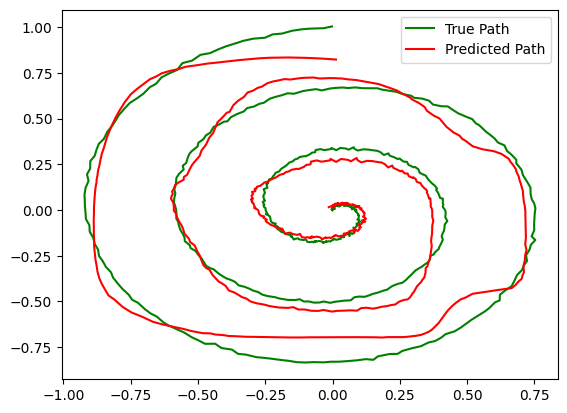

Epoch [200/2000], Total train loss: 0.0081, Total val loss: 0.0005


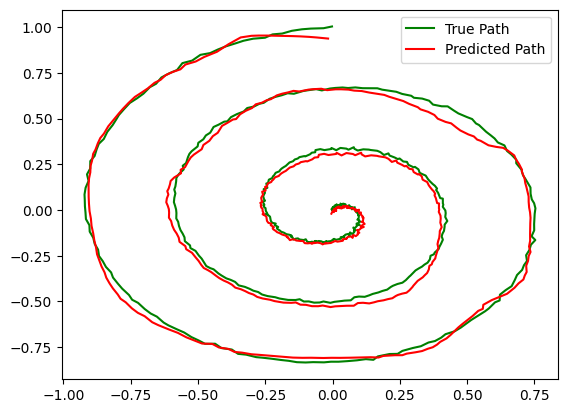

Epoch [300/2000], Total train loss: 0.0053, Total val loss: 0.0004


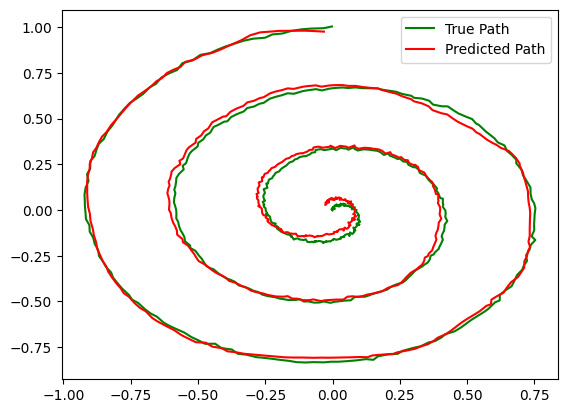

Epoch [400/2000], Total train loss: 0.0083, Total val loss: 0.0003


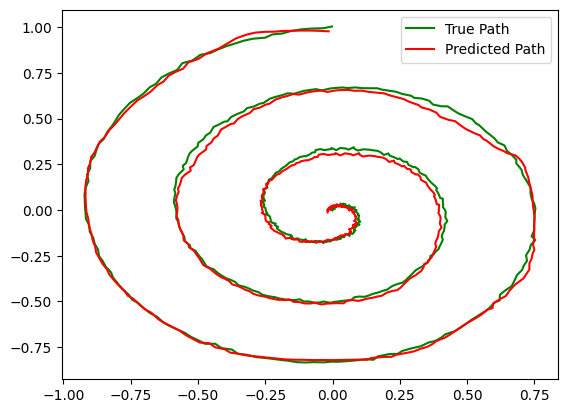

Epoch [500/2000], Total train loss: 0.0036, Total val loss: 0.0002


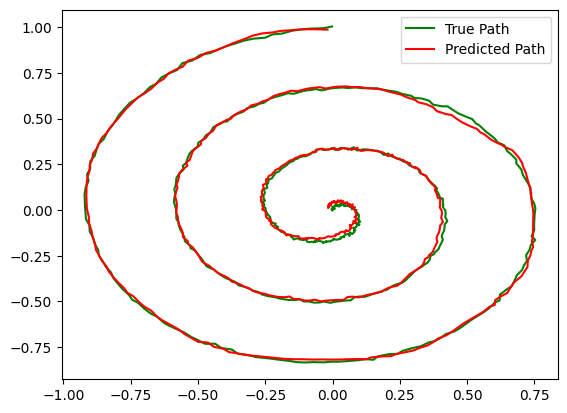

Epoch [600/2000], Total train loss: 0.0048, Total val loss: 0.0004


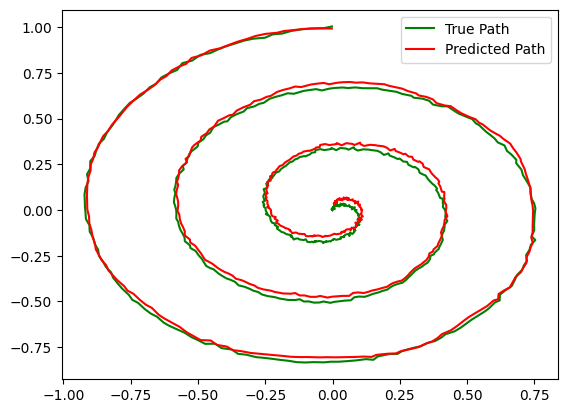

Epoch [700/2000], Total train loss: 0.0037, Total val loss: 0.0003


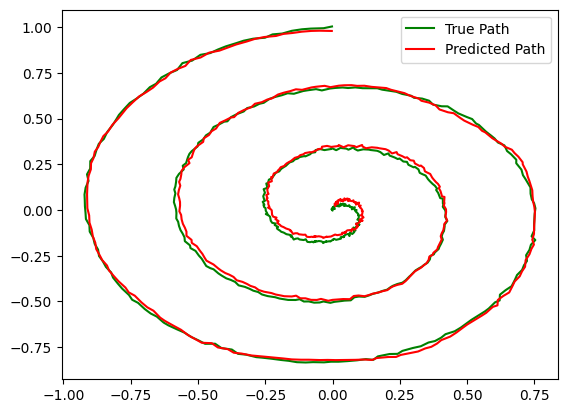

Epoch [800/2000], Total train loss: 0.0048, Total val loss: 0.0002


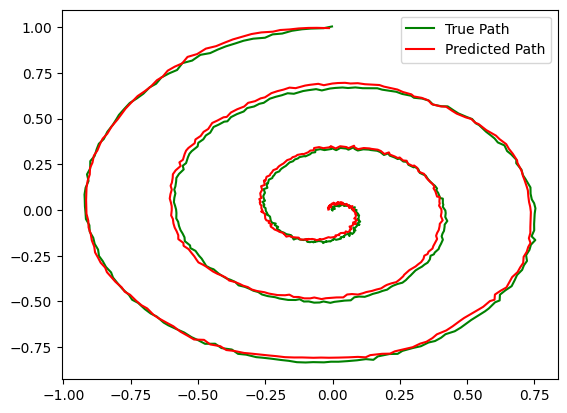

Epoch [900/2000], Total train loss: 0.0031, Total val loss: 0.0003


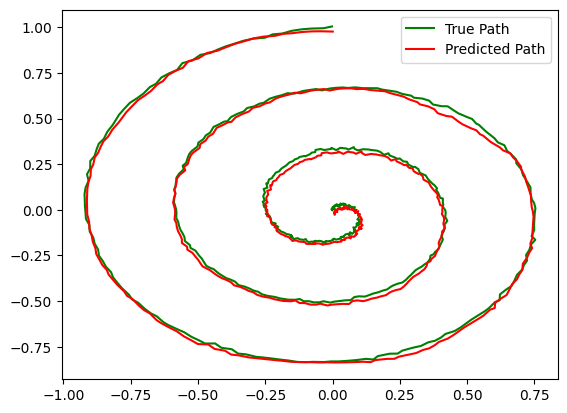

Epoch [1000/2000], Total train loss: 0.0030, Total val loss: 0.0001


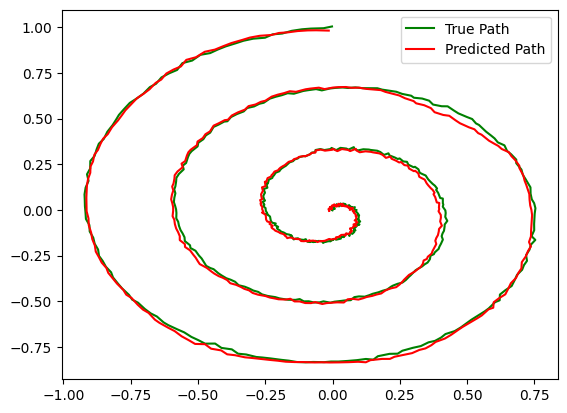

Epoch [1100/2000], Total train loss: 0.0030, Total val loss: 0.0002


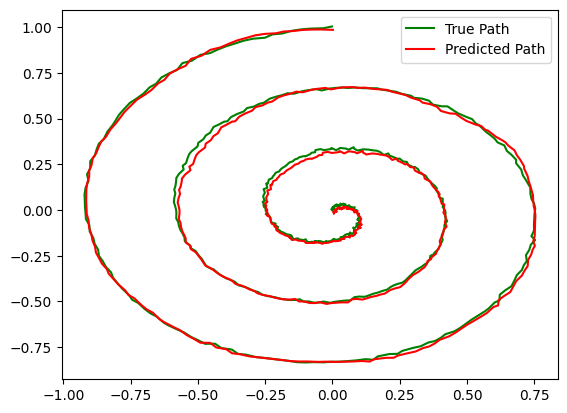

Epoch [1200/2000], Total train loss: 0.0045, Total val loss: 0.0004


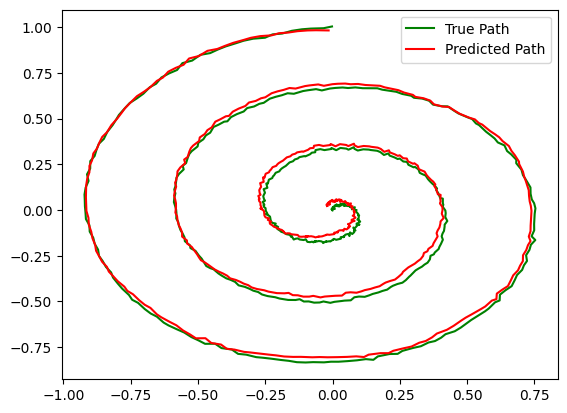

Epoch [1300/2000], Total train loss: 0.0039, Total val loss: 0.0001


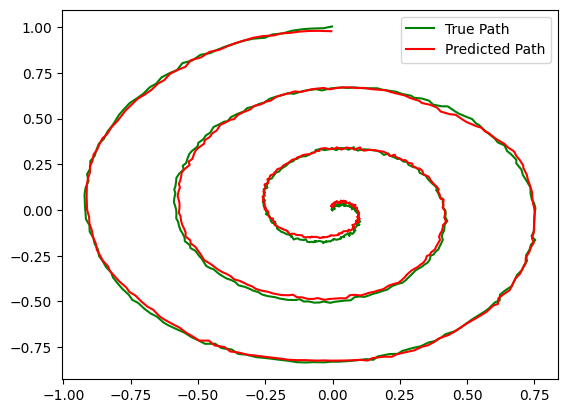

Epoch [1400/2000], Total train loss: 0.0026, Total val loss: 0.0002


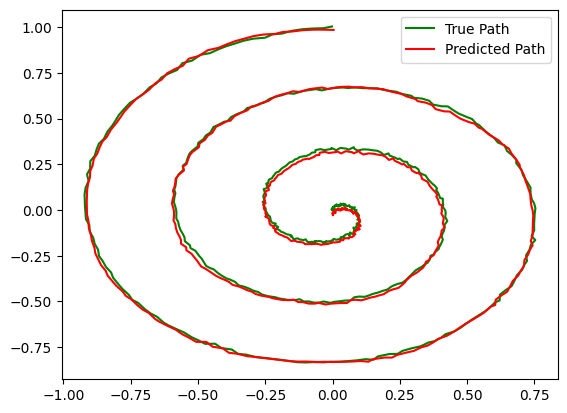

Epoch [1500/2000], Total train loss: 0.0041, Total val loss: 0.0003


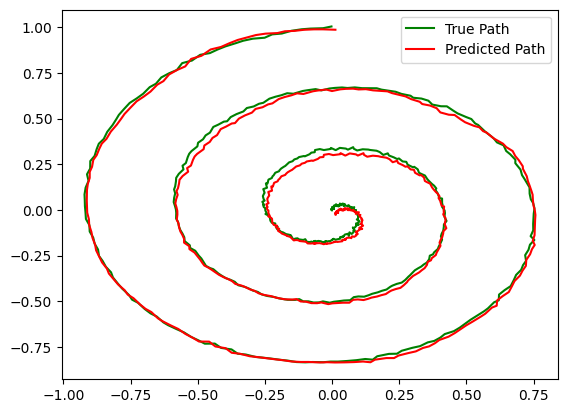

Epoch [1600/2000], Total train loss: 0.0026, Total val loss: 0.0002


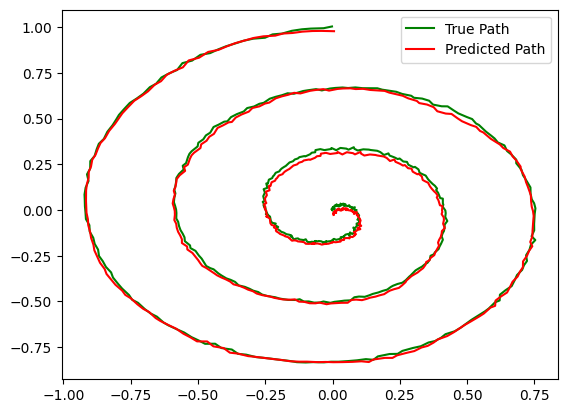

Epoch [1700/2000], Total train loss: 0.0038, Total val loss: 0.0003


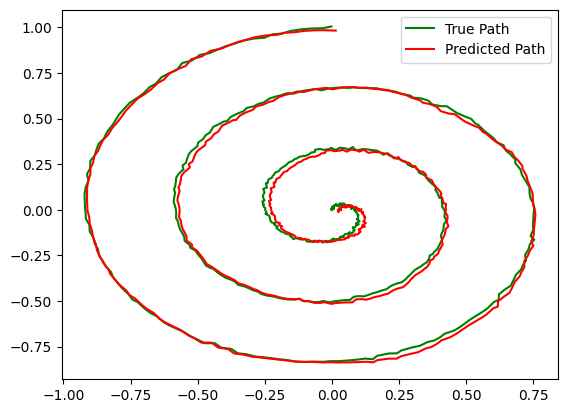

Epoch [1800/2000], Total train loss: 0.0044, Total val loss: 0.0004


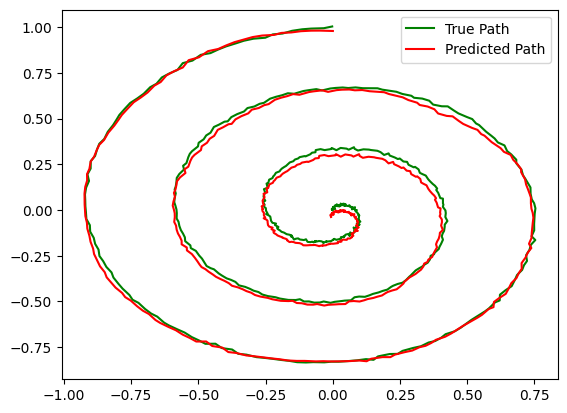

Epoch [1900/2000], Total train loss: 0.0035, Total val loss: 0.0004


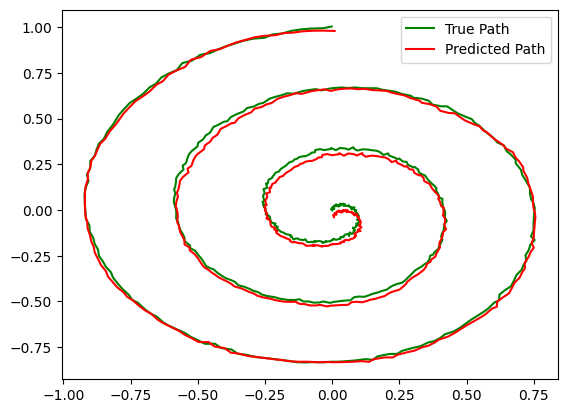

Epoch [2000/2000], Total train loss: 0.0015, Total val loss: 0.0001


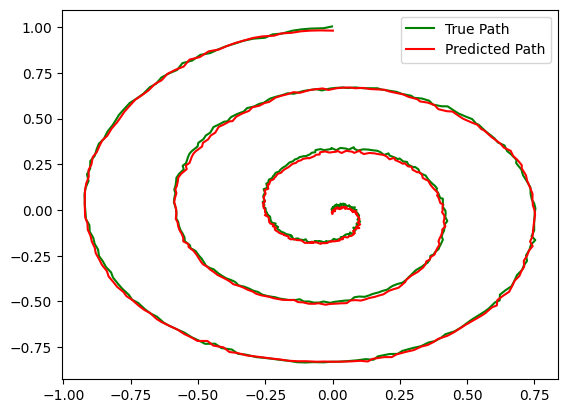

In [7]:
# Hyperparameters
input_dim = 2 # Number of input dimensions
hidden_dim = 8 # Number of hidden dimensions (number of neurons in LIFNeuralLayer)
output_dim = 2 # Number of output dimensions
num_points = 500 # Number of spiral points in dataset
num_turns = 3 # Number of spiral turns
learning_rate = 0.005
num_epochs = 2000
seq_len = 3 # Maximum length of the sample sequence
batch_size = 32

# Generate data
data = generate_spiral_data(num_points, num_turns)
all_inputs = data[:-1, :]
all_targets = data[1:, :]

# Prepare input and target sequences
trajectory_count = max(1, len(all_inputs) - seq_len)
train_inputs = [torch.FloatTensor(all_inputs[i:i + seq_len]) for i in range(trajectory_count)]
train_targets = [torch.FloatTensor(all_targets[i:i + seq_len]) for i in range(trajectory_count)]

# Shuffle and split the data for training
random_train_indices = np.arange(len(train_inputs))
np.random.shuffle(random_train_indices)
train_split_index = int(len(random_train_indices) * 0.8)
random_train_indices = random_train_indices[:train_split_index]

# Function to create batches
def create_batches(data_list, batch_size):
    return [data_list[i:i + batch_size] for i in range(0, len(data_list), batch_size)]

# Create input and target batches
train_input_batches = create_batches(train_inputs, batch_size)
train_target_batches = create_batches(train_targets, batch_size)

# Initialize model
wiring = RandomWiring(input_dim, output_dim, hidden_dim)
model = LTCRNN(wiring, input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()    
    total_loss = 0

    # Iterate over batches
    for x, y_target in zip(train_input_batches, train_target_batches):
        optimizer.zero_grad()
        x = torch.stack(x)  # Stack batch of sequences
        y_target = torch.stack(y_target)  # Stack batch of targets
        outputs = model(x)  # Forward pass through the model
        loss = criterion(outputs, y_target)  # Compute loss

        # Accumulate total loss and perform backward pass and optimization step
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Print loss every 100 epochs and plot predictions
    if (epoch + 1) % 100 == 0:
        # Prediction and plotting
        model.eval()
        with torch.no_grad():
            predictions = model(torch.FloatTensor(all_inputs).unsqueeze(0))
            # np_predictions = predictions.squeeze(0).numpy()
            np_predictions = np.array(predictions.squeeze(0).tolist())
            val_loss = criterion(predictions, torch.FloatTensor(all_targets).unsqueeze(0))  # Compute loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Total train loss: {total_loss:.4f}, Total val loss: {val_loss:.4f}')

        plt.plot(all_targets[:, 0], all_targets[:, 1], 'g-', label='True Path')
        plt.plot(np_predictions[:, 0], np_predictions[:, 1], 'r-', label='Predicted Path')
        plt.legend()
        plt.show()

In [8]:
# Save the model
# torch.save(model.state_dict(), "lnn.pt")

# Save the model, not the state dict
torch.save(model, "lnn_model.pt")

In [9]:
# Load the model
model = torch.load("lnn_model.pt", weights_only=False)



In [10]:
type(model)

__main__.LTCRNN

# Conclusions
In this tutorial we have implemented a classic LTC LNN as described in the original whitepaper. 

There are further imporvements available to the LNN architecture. 

Such as: 
* [Closed-form Continuous-Time Network models](https://arxiv.org/abs/2106.13898)
* [LTC-SE](https://arxiv.org/abs/2304.08691)
* [Liquid-S4](https://arxiv.org/abs/2209.12951)

# Model Inference

Inference Metrics:
  MSE  = 0.629520
  RMSE = 0.793423
  MAE  = 0.614248


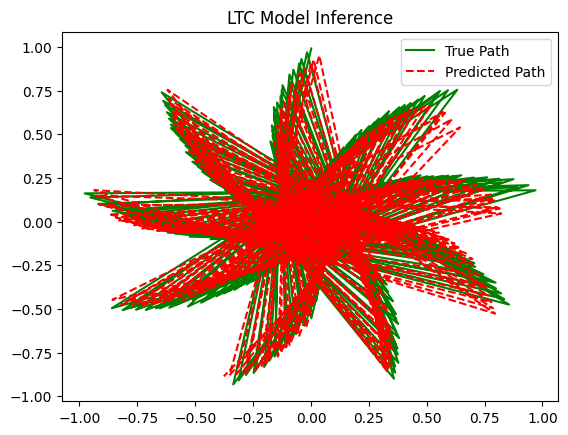

array([[ 9.86332912e-03, -2.91404291e-03],
       [ 7.99381640e-03, -1.16285821e-02],
       [ 4.18407051e-03, -6.94524404e-03],
       [ 1.06317094e-02, -2.22404599e-02],
       [-1.56020690e-02, -9.07312427e-03],
       [ 7.70884054e-03, -1.95570029e-02],
       [-1.26348520e-02, -2.50841156e-02],
       [ 1.62428357e-02, -3.29677394e-04],
       [-1.39031478e-03, -1.99405495e-02],
       [-1.10841990e-02,  4.71927738e-03],
       [ 4.15632641e-03, -1.35353971e-02],
       [-1.77927110e-02,  1.09192748e-02],
       [ 2.73734145e-02, -2.01296173e-02],
       [-5.08210361e-02, -5.87929925e-03],
       [ 4.15678583e-02, -1.38761587e-02],
       [-5.77967912e-02, -3.30928750e-02],
       [ 4.04183567e-02,  1.01122083e-02],
       [-2.41643582e-02, -3.57397087e-02],
       [ 2.10783090e-02,  2.91446019e-02],
       [ 2.23520193e-02, -3.59253697e-02],
       [-3.30518745e-02,  2.24164743e-02],
       [ 5.43721244e-02, -2.46220455e-02],
       [-6.96022958e-02, -6.35621278e-03],
       [ 7.

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

def infer_spiral(model, input_seq, target_seq=None):
    model.eval()
    with torch.no_grad():
        x = torch.FloatTensor(input_seq).unsqueeze(0)  # Shape: [1, seq_len, input_dim]
        predictions = model(x).squeeze(0).numpy()      # Shape: [seq_len, output_dim]

    if target_seq is not None:
        if isinstance(target_seq, torch.Tensor):
            target_seq = target_seq.numpy()
        
        mse = mean_squared_error(target_seq, predictions)
        mae = mean_absolute_error(target_seq, predictions)
        rmse = np.sqrt(mse)

        # Print metrics
        print(f"Inference Metrics:")
        print(f"  MSE  = {mse:.6f}")
        print(f"  RMSE = {rmse:.6f}")
        print(f"  MAE  = {mae:.6f}")

        plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(predictions[:, 0], predictions[:, 1], 'r--', label='Predicted Path')
    plt.legend()
    plt.title("LTC Model Inference")
    plt.show()

    return predictions


# Change num_points and num_turns here to give input diff shape
test_data = generate_spiral_data(num_points=300, num_turns=10000)

# Prepare input and target pairs
test_inputs = test_data[:-1, :]    # Inputs: from 0 to N-2
test_targets = test_data[1:, :]    # Targets: from 1 to N-1


# infer_spiral(model, all_inputs, all_targets)
infer_spiral(model, test_inputs, test_targets)
# infer_spiral(model, test_inputs[:3], test_targets[:3])

# FGSM Attack

In [50]:
def run_manual_fgsm_attack(model, input_seq, target_seq, epsilon=0.05):
    model.eval()

    # Convert to tensors
    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0).requires_grad_(True)  # [1, seq_len, input_dim]
    target_tensor = torch.FloatTensor(target_seq).unsqueeze(0)                      # [1, seq_len, output_dim]

    # Forward pass
    output = model(input_tensor)
    loss = F.mse_loss(output, target_tensor)

    # Backward pass to compute gradients
    model.zero_grad()
    loss.backward()

    # Generate perturbation using the sign of the gradient
    perturbation = epsilon * input_tensor.grad.data.sign()
    adv_input = input_tensor + perturbation
    adv_input = adv_input.detach()

    # Get adversarial output
    adv_output = model(adv_input).squeeze(0).detach().numpy()
    original_output = output.squeeze(0).detach().numpy()

    # Plot results
    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='Adversarial Prediction')
    plt.legend()
    plt.title(f"Manual FGSM Attack (epsilon={epsilon})")
    plt.show()

    return adv_output

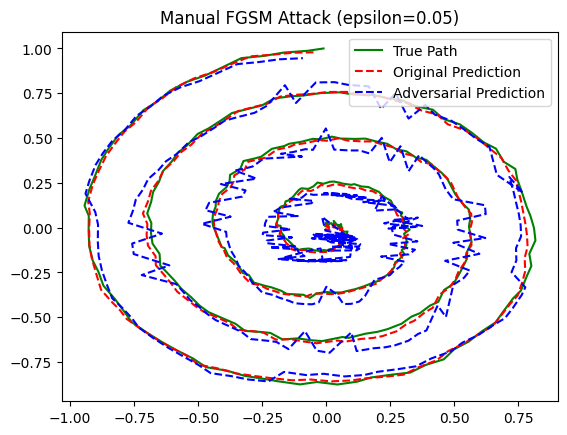

array([[ 4.72087078e-02, -7.21365660e-02],
       [-5.65922037e-02, -5.95944747e-02],
       [ 6.14745580e-02, -6.21868409e-02],
       [ 4.80462946e-02, -5.20860627e-02],
       [-5.30737452e-02, -4.77897488e-02],
       [ 5.64089939e-02, -4.22304273e-02],
       [-5.35732284e-02, -3.41369808e-02],
       [-4.57267836e-02, -4.34314162e-02],
       [-3.74082848e-02, -4.09252308e-02],
       [ 7.20662326e-02, -4.26422656e-02],
       [-2.94811167e-02, -4.25254554e-02],
       [-2.54749861e-02, -4.45968360e-02],
       [ 8.40126425e-02, -5.10052554e-02],
       [-1.69275291e-02,  6.01057857e-02],
       [-3.25126247e-03, -1.63376871e-02],
       [ 1.09453037e-01, -5.06512336e-02],
       [-4.67913877e-03, -5.31701483e-02],
       [ 1.09161779e-01, -5.34897782e-02],
       [ 1.10212706e-01, -6.01069964e-02],
       [-1.86303968e-03, -5.87922558e-02],
       [ 1.13885529e-01, -6.77575469e-02],
       [ 5.52913733e-03, -7.33962730e-02],
       [ 1.98074691e-02, -8.26118514e-02],
       [ 1.

In [55]:
test_data = generate_spiral_data(300, 4)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on a short sequence
run_manual_fgsm_attack(model, test_input, test_target, epsilon=0.05)


# PGD Attack

In [ ]:
def run_pgd_attack(model, input_seq, target_seq, epsilon=0.05, alpha=0.01, num_iter=10):
    model.eval()

    # Prepare inputs
    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0)
    target_tensor = torch.FloatTensor(target_seq).unsqueeze(0)

    adv_input = input_tensor.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        output = model(adv_input)
        loss = F.mse_loss(output, target_tensor)

        model.zero_grad()
        loss.backward()

        # Gradient ascent: move in the direction that increases loss
        with torch.no_grad():
            adv_input += alpha * adv_input.grad.sign()

            # Project perturbation back into epsilon-ball of original input
            perturbation = torch.clamp(adv_input - input_tensor, min=-epsilon, max=epsilon)
            adv_input = torch.clamp(input_tensor + perturbation, min=input_tensor.min(), max=input_tensor.max())
            adv_input.requires_grad_(True)

    # Final prediction
    adv_output = model(adv_input).squeeze(0).detach().numpy()
    original_output = model(input_tensor).squeeze(0).detach().numpy()

    # Plot comparison
    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='PGD Adversarial Prediction')
    plt.legend()
    plt.title(f"PGD Attack (epsilon={epsilon}, alpha={alpha}, iter={num_iter})")
    plt.show()

    return adv_output

In [ ]:
test_data = generate_spiral_data(300, 4)
test_input = test_data[:-1]
test_target = test_data[1:]

# Use the first 50 time steps
run_pgd_attack(model, test_input[:50], test_target[:50], epsilon=0.05, alpha=0.01, num_iter=15)